In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Image properties 

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

### Load Data

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

### Visualization

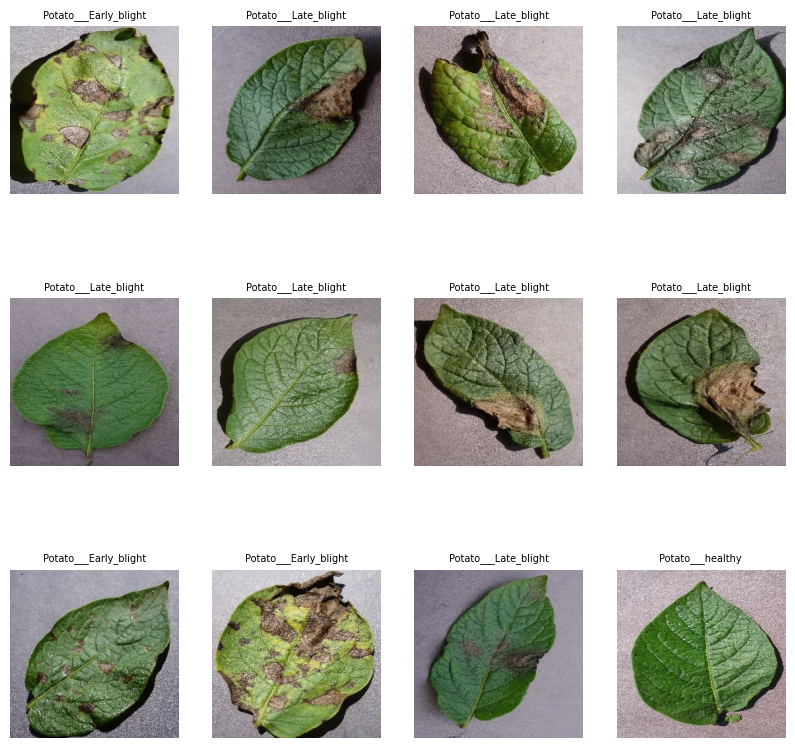

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    #print(image_batch.shape)#(32, 256, 256, 3)
    #print(label_batch.numpy())#[1 1 0 1 0 1 0 2 0 0 0 1 1 0 1 1 1 2 1 0 0 2 1 1 1 1 1 0 1 0 0 0]
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]],fontsize=7)
        plt.axis("off")
    

In [7]:
len(dataset)

68

In [8]:
# 80% ==> training
# 20% ==> 10%validation, 10% test

### Partitioning

In [9]:
def data_partitions(ds,train_split,val_split,test_split,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)

    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size)
    val_ds=test_ds.take(val_size)
    test_ds=test_ds.skip(val_size)

    return train_ds,val_ds, test_ds
    

In [10]:
train_ds,val_ds,test_ds=data_partitions(dataset,0.8,0.1,0.1)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Preprocessing 

### Create the layers 

* Rescaling and Resizing

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

* Augmentation

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
     
])

### Model Building

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


54/54 [==============================] - 208s 4s/step - loss: 0.8905 - accuracy: 0.5058 - val_loss: 0.7482 - val_accuracy: 0.5781
Epoch 2/50
54/54 [==============================] - 160s 3s/step - loss: 0.8099 - accuracy: 0.5949 - val_loss: 0.6352 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 184s 3s/step - loss: 0.6046 - accuracy: 0.7130 - val_loss: 0.4577 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 180s 3s/step - loss: 0.3951 - accuracy: 0.8374 - val_loss: 0.3525 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 283s 5s/step - loss: 0.2708 - accuracy: 0.9062 - val_loss: 0.1526 - val_accuracy: 0.9583
Epoch 6/50
 1/54 [..............................] - ETA: 3:27 - loss: 0.2829 - accuracy: 0.9062